# Лекция 4

In [72]:
!pip install arch

In [73]:
# Commented out IPython magic to ensure Python compatibility.
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.tsa.arima.model as smta
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import boxcox
from math import sqrt
from arch import arch_model

In [74]:
# Проверка стационарности временного ряда
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [75]:
# Визуализация временного ряда
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Original')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [76]:
# Загрузка данных
series = pd.read_csv('D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/international-airline-passengers.csv').dropna().values[:, 1]

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


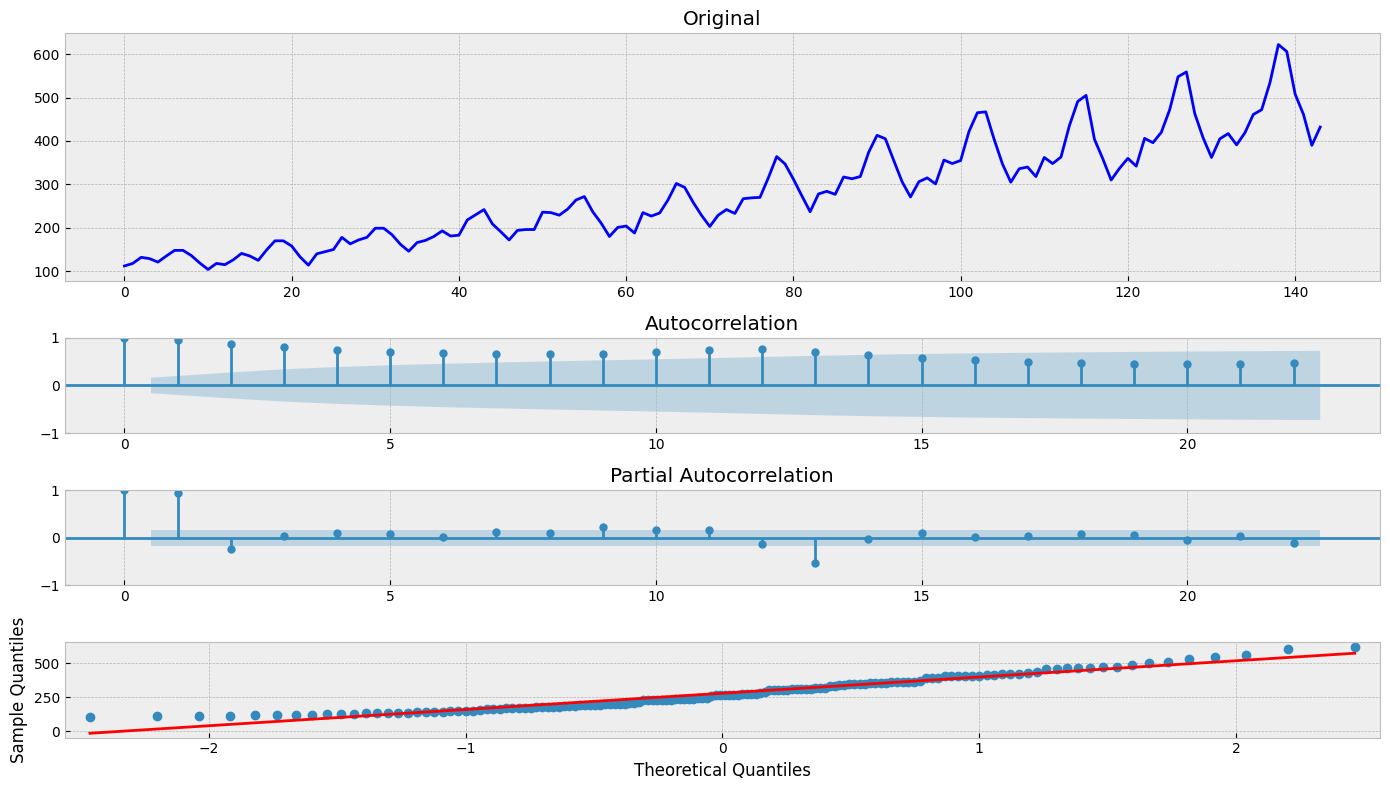

In [77]:
# Визуализация исходного временного ряда
tsplot(series)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.492197
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


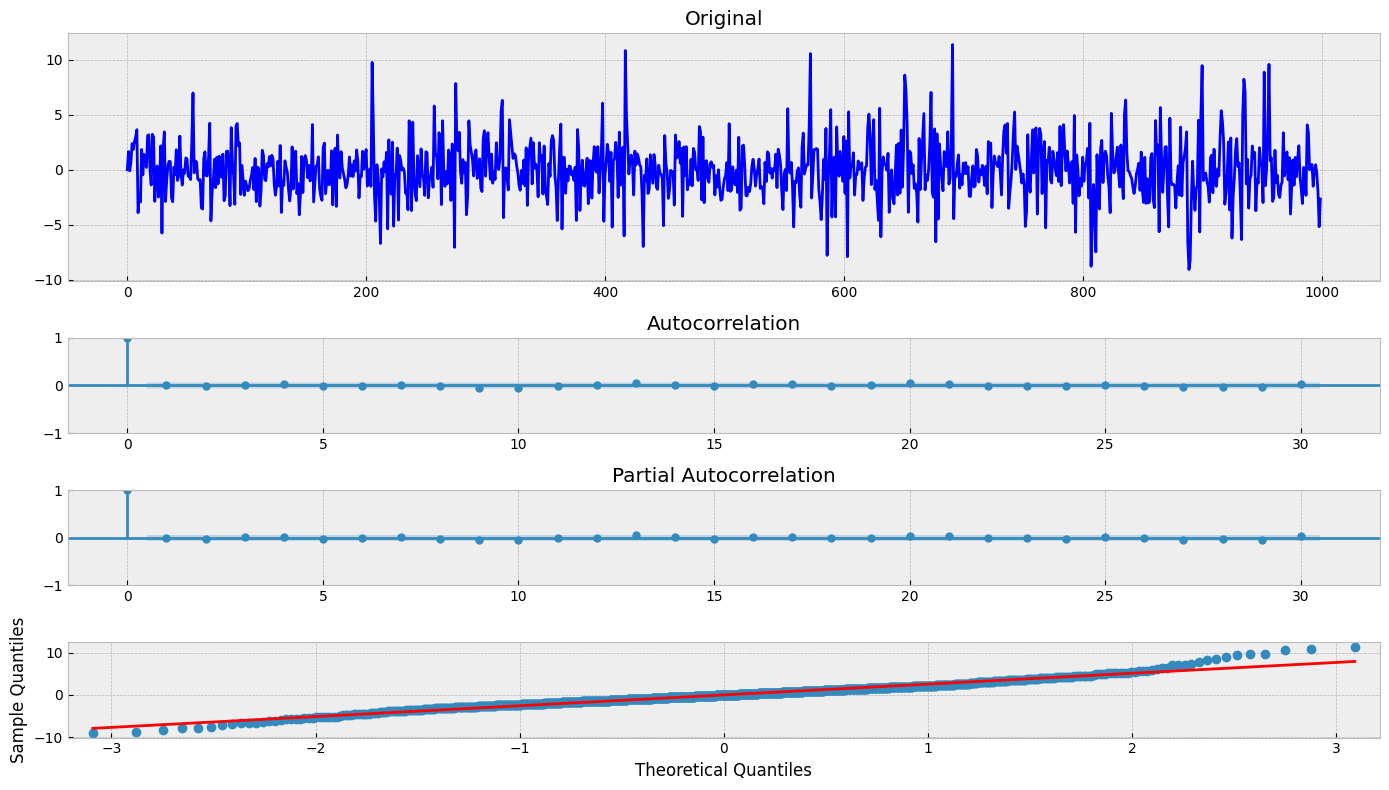

In [78]:
# Симуляция ARCH(1) процесса
np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(1, len(y)):
    Y[t] = w[t] * np.sqrt(a0 + a1 * y[t-1]**2)

# Визуализация симулированного ряда ARCH(1)
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


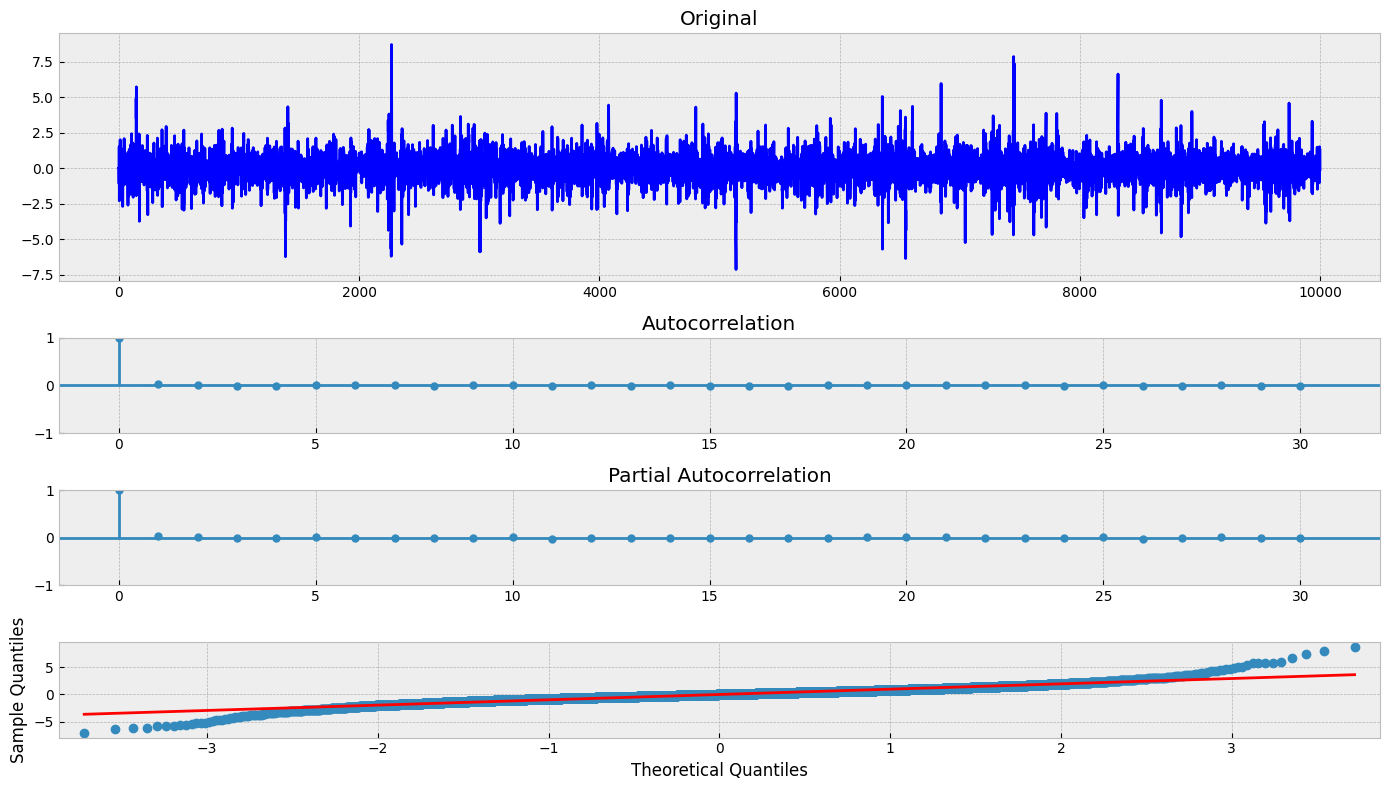

In [79]:
# Симуляция процесса GARCH(1, 1)
np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1 * (eps[i-1]**2) + b1 * sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

# Визуализация симулированного ряда GARCH(1, 1)
tsplot(eps, lags=30)

In [80]:
# Применение модели ARCH к симулированному ряду
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.790134449831
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312781716888
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318712
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sat, Mar 15 2025   Df Residuals:                     9999
Time:       

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [81]:
series = series.astype(float)

In [82]:
# Функция для поиска лучшей модели ARIMA
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    # Указываем тренд при создании модели
                    tmp_mdl = smta.ARIMA(TS, order=(i, d, j)).fit()
                    tmp_aic = tmp_mdl.aic

                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(f'Error for order {(i, d, j)}: {e}')
                    continue
    print('Best model: aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

# Поиск лучшей модели ARIMA
aic, order, mdl = _get_best_model(series)

d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive param

Best model: aic: 1342.38929 | order: (4, 1, 4)


d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


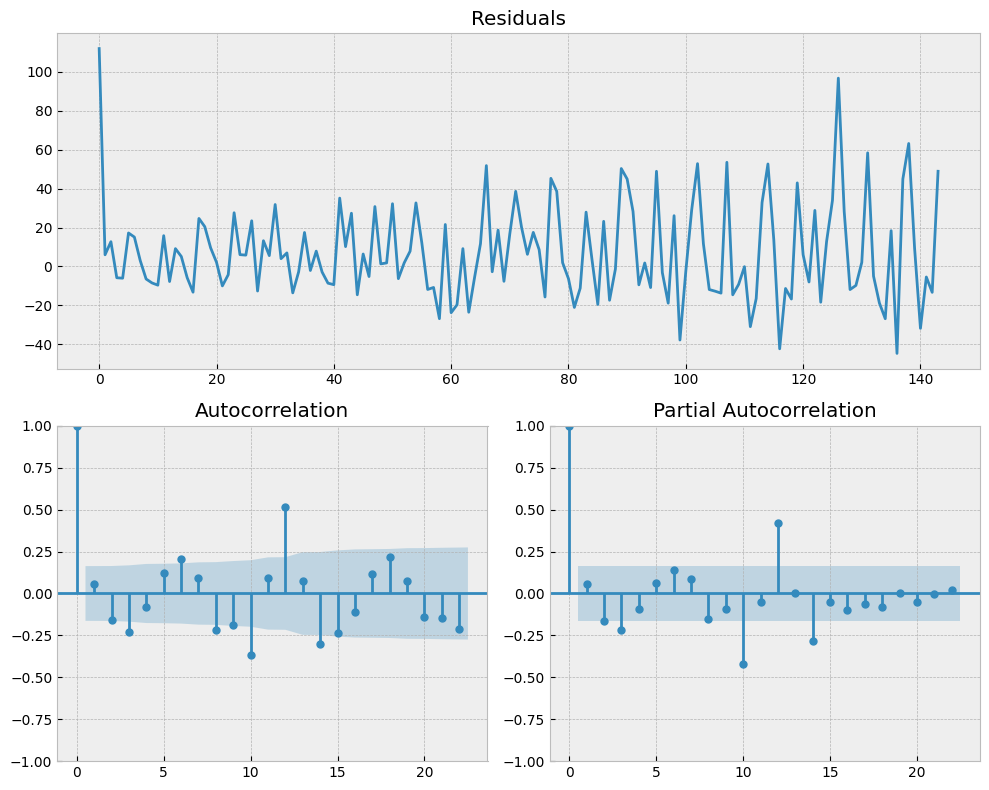

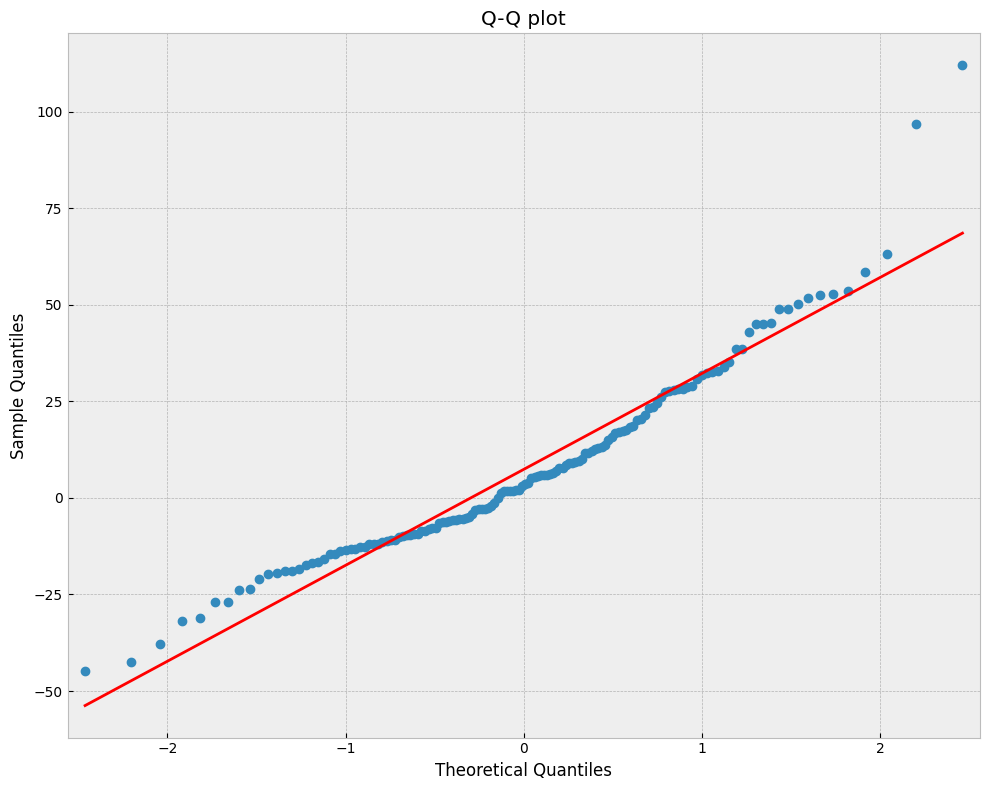

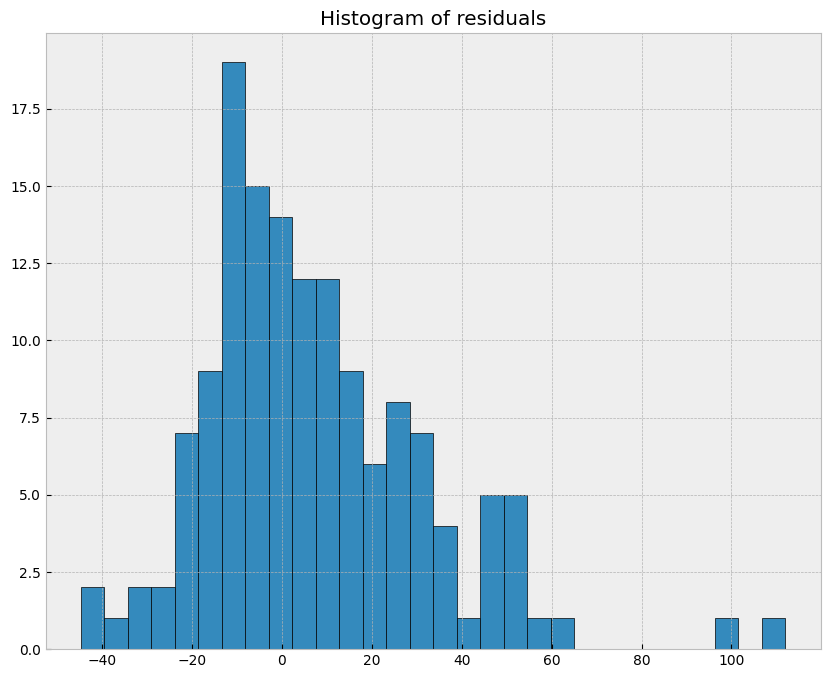

In [83]:
# Функция для построения графиков остатков модели
def tsplot1(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, (pd.Series, np.ndarray)):
        y = np.array(y)

    plt.style.use(style)
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    ts_ax.plot(y)
    ts_ax.set_title('Residuals')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(10, 8))
    qq_ax = fig.add_subplot(111)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('Q-Q plot')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.hist(y, bins=30, edgecolor='k')
    plt.title('Histogram of residuals')
    plt.show()

# Визуализация остатков модели
tsplot1(mdl.resid)

Применим GARCH

In [84]:
# Преобразование временного ряда для применения модели GARCH
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [85]:
# Преобразование серии в числовой формат
series = series.astype(float)

In [86]:
# Применение модели GARCH к временной серии
p_ = 3
o_ = 1
q_ = 3

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(series, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -507.387
Distribution:      Standardized Student's t   AIC:                           1024.77
Method:                  Maximum Likelihood   BIC:                           1039.15
                                              No. Observations:                  131
Date:                      Sat, Mar 15 2025   Df Residuals:                      130
Time:                              09:27:42   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


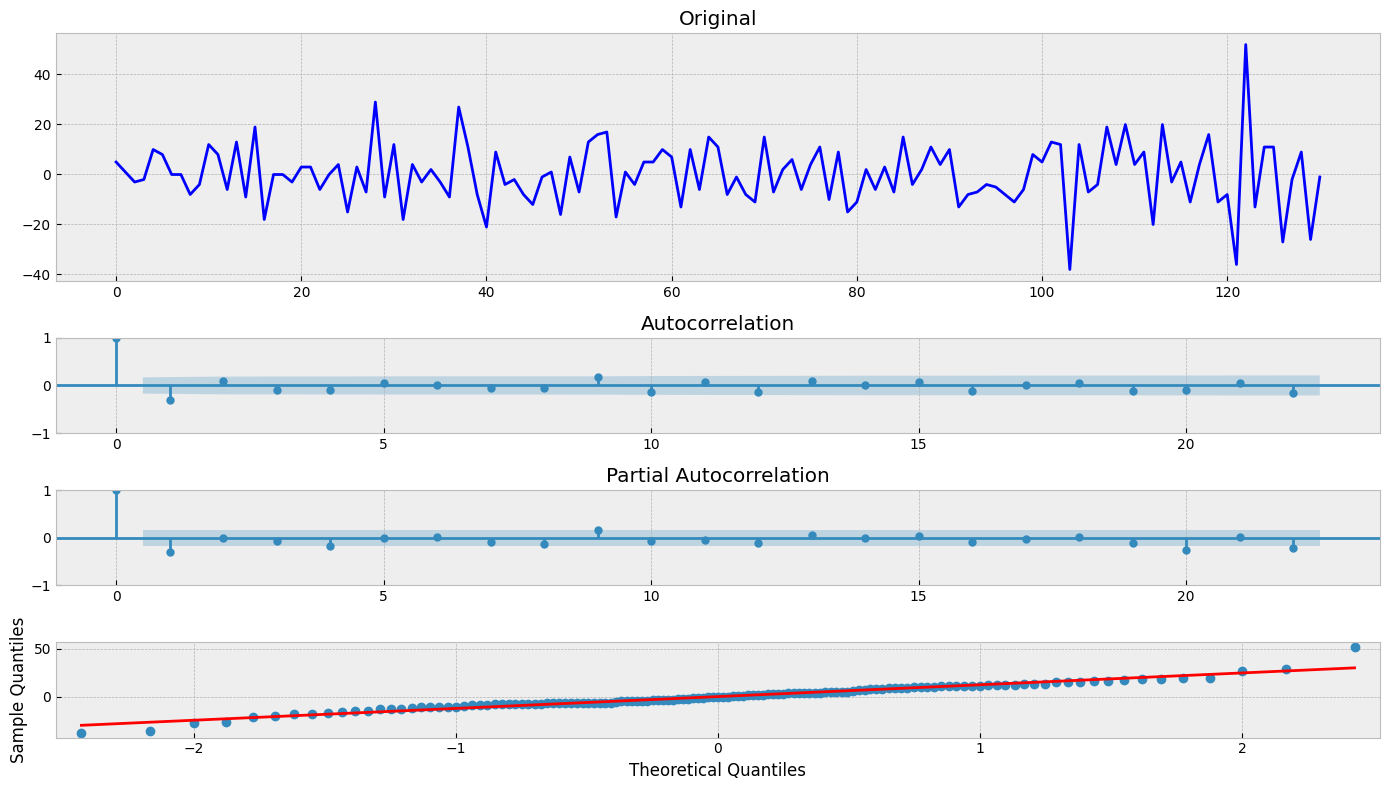

In [87]:
# Визуализация остатков модели GARCH
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


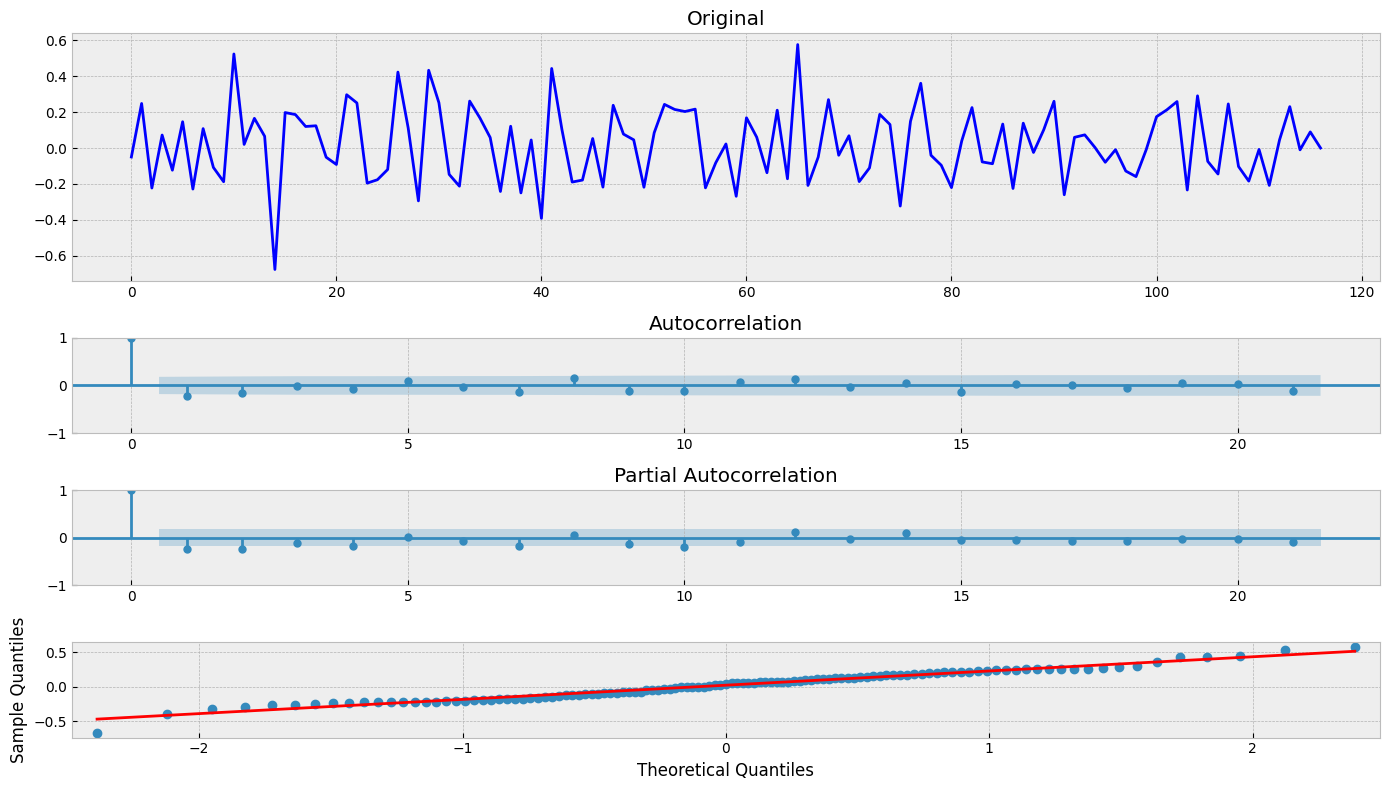

In [88]:
# Загрузка и преобразование данных
new_series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]

# Визуализация новой временной серии
tsplot(new_series)

In [89]:
# Поиск лучшей модели ARIMA для новой временной серии
aic, order, mdl = _get_best_model(new_series)

d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
d:\Documents\python

Best model: aic: -49.13325 | order: (1, 0, 1)


d:\Documents\python_projects\Netology\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results of Dickey-Fuller Test:
Test Statistic                -1.086133e+01
p-value                        1.443879e-19
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


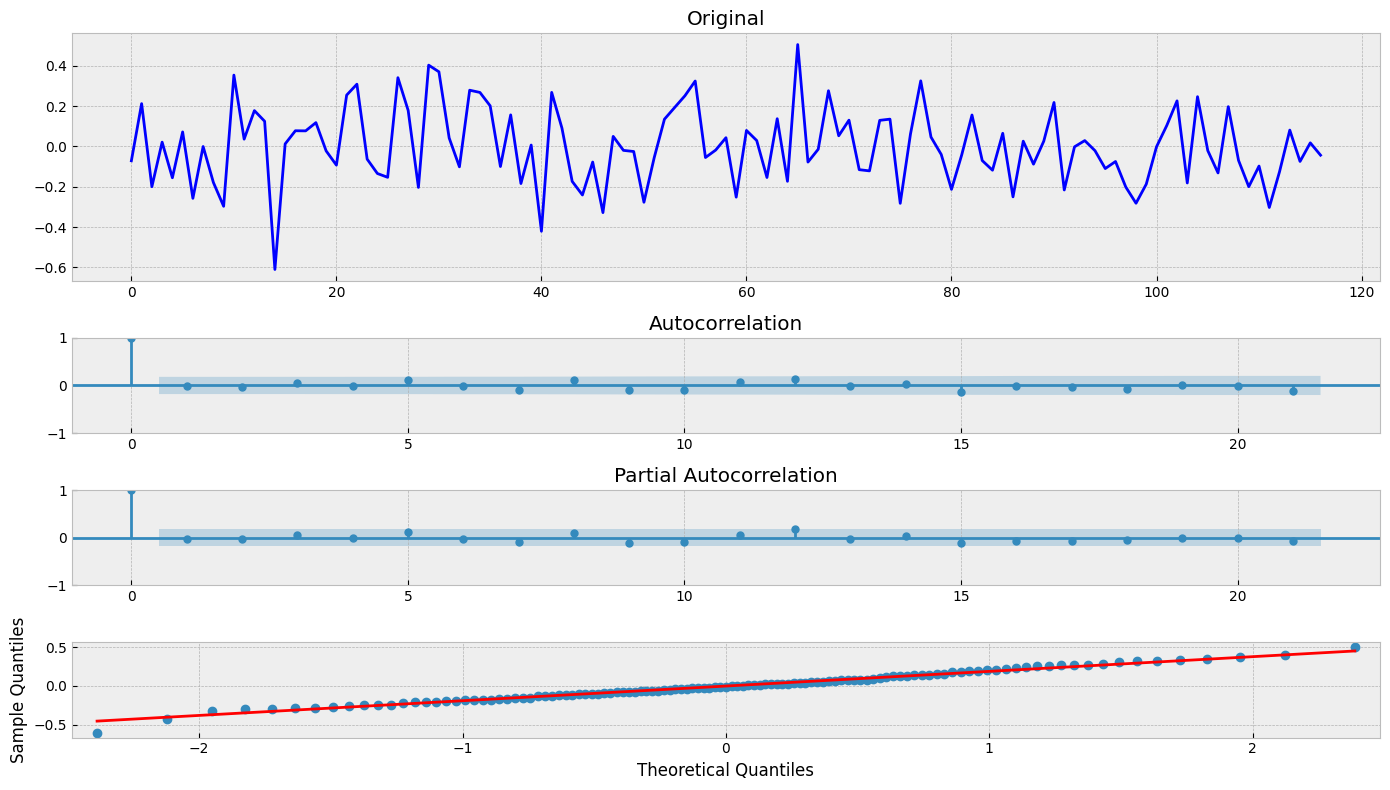

In [90]:
# Визуализация остатков новой модели
tsplot(mdl.resid)

In [91]:
order

(1, 0, 1)

In [92]:
# Применение модели GARCH к новой временной серии
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Использование распределения Стьюдента для улучшения подгонки
am = arch_model(new_series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 519.2231688772044
Iteration:     10,   Func. Count:     65,   Neg. LLF: 518.3540407391816
Iteration:     15,   Func. Count:     95,   Neg. LLF: 518.2217839460429
Optimization terminated successfully    (Exit mode 0)
            Current function value: 518.1478339607132
            Iterations: 19
            Function evaluations: 129
            Gradient evaluations: 19
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -518.148
Distribution:      Standardized Student's t   AIC:                           1046.30
Method:                  Maximum Likelihood   BIC:                           1060.11
                                              No. Observations: 

In [93]:
# Прогнозирование на основе модели GARCH
forecast = res.forecast(horizon=100)

In [94]:
new_series.shape

(117,)

In [95]:
new_series[-5:]

array([ 0.0453152 ,  0.23070979, -0.0101011 ,  0.08975718,  0.        ])

In [96]:
forecast

In [97]:
forecast.residual_variance.iloc[-1]

h.001    279.736018
h.002    278.274882
h.003    276.821377
h.004    275.375465
h.005    273.937105
            ...    
h.096    170.091387
h.097    169.202956
h.098    168.319165
h.099    167.439991
h.100    166.565409
Name: 116, Length: 100, dtype: float64

[279.73601803 278.2748818  276.82137749 275.37546525 273.93710542
 272.50625856 271.08288541 269.66694694 268.25840432 266.85721891
 265.4633523  264.07676624 262.69742272 261.3252839  259.96031215
 258.60247003 257.25172031 255.90802593 254.57135006 253.24165602
 251.91890734 250.60306776 249.29410118 247.99197171 246.69664363
 245.40808141 244.12624972 242.85111339 241.58263747 240.32078715
 239.06552784 237.8168251  236.57464469 235.33895254 234.10971476
 232.88689764 231.67046764 230.4603914  229.25663572 228.05916761
 226.86795421 225.68296285 224.50416104 223.33151645 222.16499691
 221.00457044 219.8502052  218.70186953 217.55953195 216.42316112
 215.29272588 214.16819522 213.04953831 211.93672446 210.82972314
 209.72850401 208.63303686 207.54329165 206.45923848 205.38084763
 204.30808952 203.24093473 202.179354   201.1233182  200.07279837
 199.02776571 197.98819154 196.95404737 195.92530483 194.9019357
 193.88391192 192.87120556 191.86378885 190.86163417 189.86471403
 188.873001

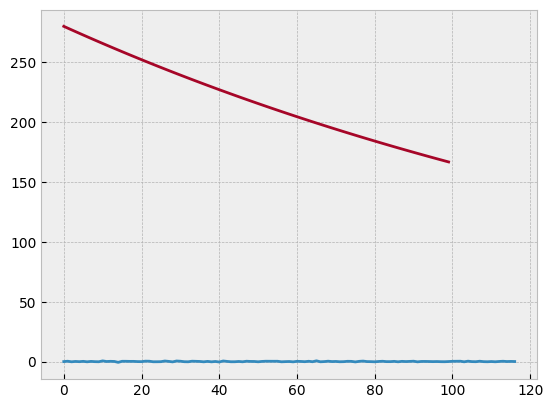

In [98]:
# Визуализация прогнозов и остатков
plt.plot(new_series)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*100 + forecast.residual_variance.iloc[-1].values)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


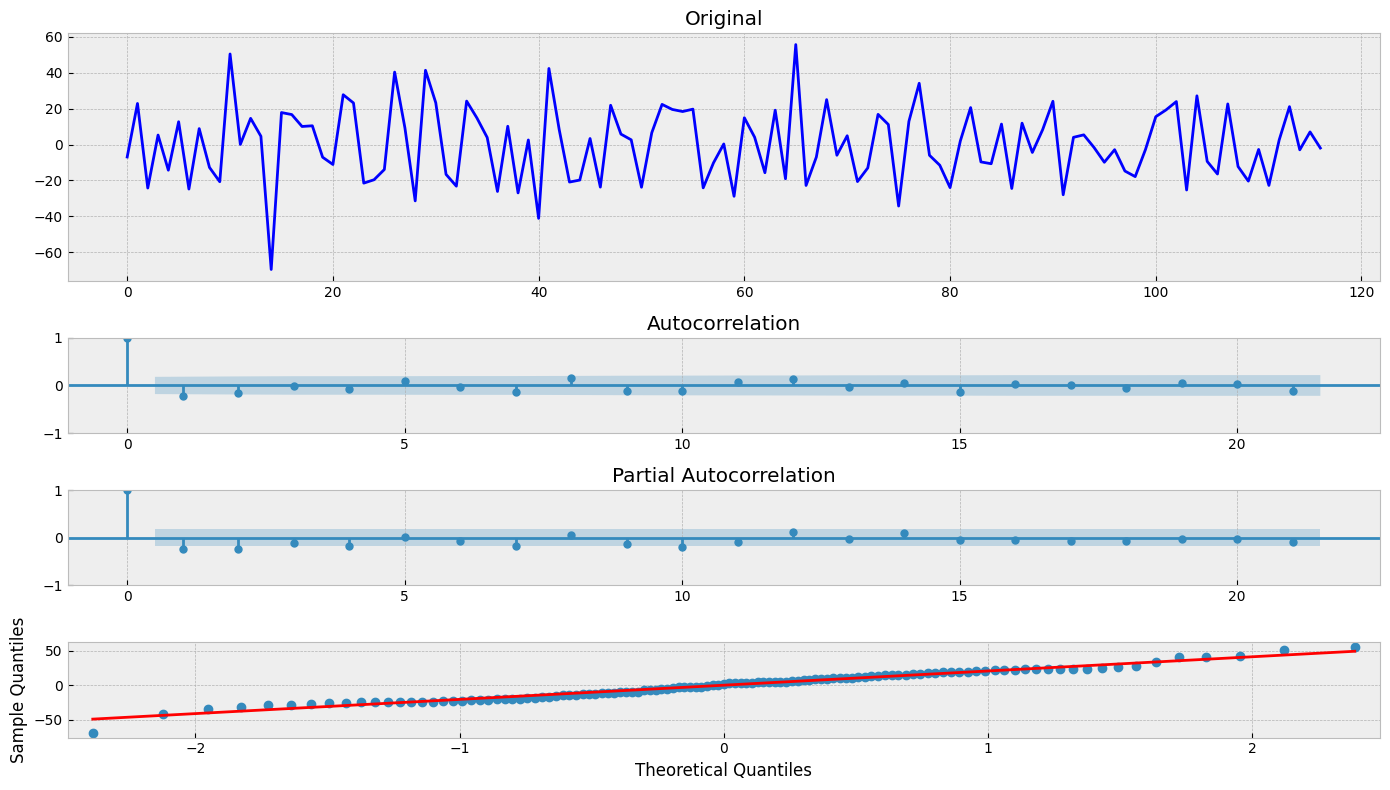

In [99]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [100]:
# Загрузка данных
series = pd.read_csv("D:/Documents/python_projects/Netology/venv/times_series/1_introductions_with_times_series/1._Лекция_tsml/Series/international-airline-passengers.csv")

In [105]:
series

,Month,Count
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [101]:
# Создание дополнительных признаков на основе временного ряда
s = pd.DataFrame(series['Count'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s[f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,104,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
11,118,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
12,115,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
13,126,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
14,141,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [102]:
# Подготовка данных для обучения и тестирования модели
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # Индекс начала тестовой выборки
    test_index = int(len(data)*(1-test_size))

    # Добавление лагов исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)

    # Разделение данных на обучающую и тестовую выборки
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [103]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

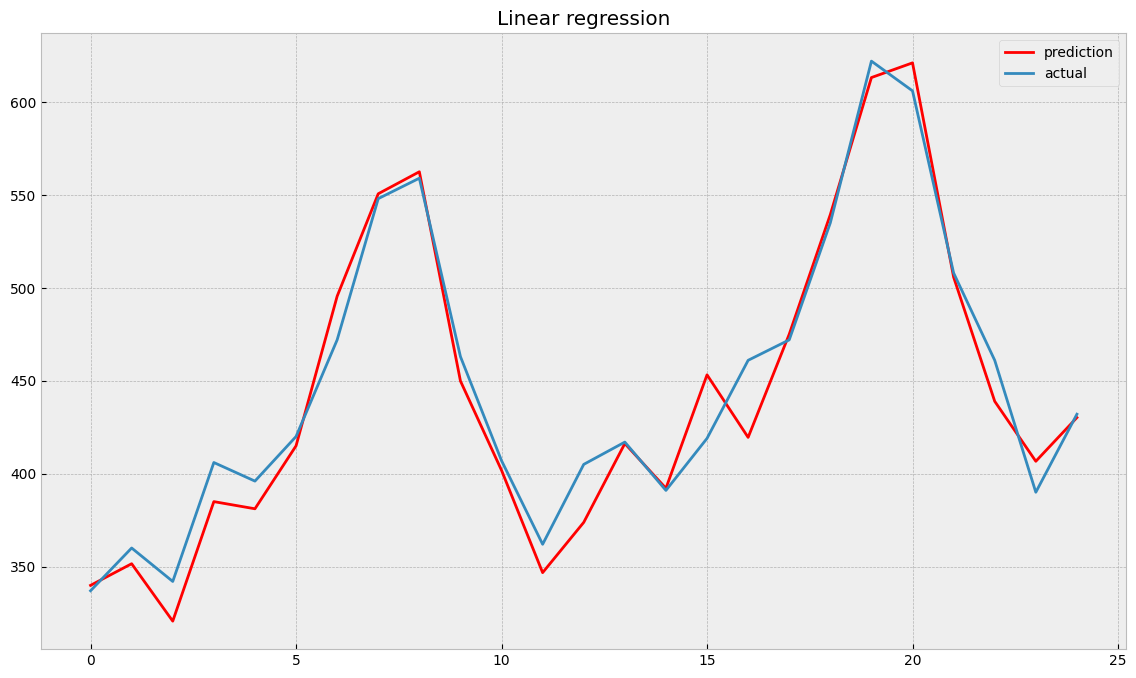

In [104]:
# Обучение модели линейной регрессии
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

# Визуализация прогнозов и фактических значений
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True)

# Домашнее задание
- Выберите ряд и постройте его модель GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016